In [ ]:
#get the project

In [ ]:
%cd /content/assignment3-21-robustnet-1/

In [ ]:
!pip install -r requirements.txt

In [ ]:
#!/usr/bin/env python3 
import os
import argparse
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from random import randint

from attacks import *
from utils import *

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

valid_size = 1024
batch_size = 32
criterion = nn.NLLLoss()
'''Basic neural network architecture (from pytorch doc).'''


class Net(nn.Module):
    model_file = "models/default_model.pth"
    '''This file will be loaded to test your model. Use --model-file to load/store a different model.'''

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def save(self, model_file):
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device)))

    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.
           
           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''
        self.load(os.path.join(project_dir, Net.model_file))


def train_model(net, train_loader, pth_filename, num_epochs):
    '''Basic training function'''
    print("Starting training")

    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    train_loss = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        loss_per_epoch = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)  
             #Add adversarial data
            adv_data=projected_gradient_descent(net,inputs,0.08,1/255,40,np.inf)
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(adv_data)
            loss = criterion(outputs, labels)
            loss_per_epoch += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = loss_per_epoch / (len(train_loader))
        train_loss.append(epoch_loss)
        print(f'epoch : {epoch} --- loss : {epoch_loss} ')

    net.save(pth_filename)
    print('Model saved in {}'.format(pth_filename))
    return train_loss


####### Testing ############
def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


######################## Attack Testing ########################
def test_fgsm(net, test_loader, epsilon):
    correct = 0
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images.requires_grad = True
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, nat_pred = torch.max(outputs.data, 1)
        if nat_pred.item() != labels.item():
            continue
        # if test sample is correctly predicted
        loss = criterion(outputs, labels)
        net.zero_grad()
        loss.backward()

        data_grad = images.grad.data
        adv_data = fgsm(images, epsilon, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return 100 * final_acc


def test_pgdlinf(net, test_loader, eta, eps, steps):
    correct = 0
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        adv_data = images.clone().detach().to(device)
        for _ in range(steps):
            # calculate outputs by running images through the network
            adv_data.requires_grad = True
            outputs = net(adv_data)

            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():
                break
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = adv_data.grad.data
            adv_data = pgdlinf(adv_data, images, eta, eps, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))
    return 100 * final_acc


def test_pgdl2(net, test_loader, eta, eps, steps, eps_for_div):
    correct = 0
    for i, data in enumerate(test_loader, 0):

        images, labels = data[0].to(device), data[1].to(device)
        adv_data = images.clone().detach().to(device)
        for _ in range(steps):

            adv_data.requires_grad = True
            outputs = net(adv_data)

            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():

                break
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = adv_data.grad.data
            adv_data = pgdl2(adv_data, images, eta, eps, eps_for_div, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))
    return 100 * final_acc



##########################################

def get_train_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the training part.'''

    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    return train


def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the validation part.'''

    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

    return valid



In [ ]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_88.pth", 20)
print("Model save to '{}'.".format("models/adversarial_88.pth"))

Files already downloaded and verified
Starting training
epoch : 0 --- loss : 0.973488020671107 
epoch : 1 --- loss : 0.9600703979457305 
epoch : 2 --- loss : 0.9537906113362328 
epoch : 3 --- loss : 0.9503382447885579 
epoch : 4 --- loss : 0.9472881838981035 
epoch : 5 --- loss : 0.9451755201948927 
epoch : 6 --- loss : 0.9436870182673966 
epoch : 7 --- loss : 0.9403053027286318 
epoch : 8 --- loss : 0.9391395534509774 
epoch : 9 --- loss : 0.9377188056142871 
epoch : 10 --- loss : 0.9339689604212925 
epoch : 11 --- loss : 0.9332083559441146 
epoch : 12 --- loss : 0.9322303326826015 
epoch : 13 --- loss : 0.9312130175409249 
epoch : 14 --- loss : 0.9300208698293884 
epoch : 15 --- loss : 0.9294011833463752 
epoch : 16 --- loss : 0.9268937439485596 
epoch : 17 --- loss : 0.925150626200932 
epoch : 18 --- loss : 0.9256701155630769 
epoch : 19 --- loss : 0.9222189228881971 
Model saved in models/adversarial_88.pth
Model save to 'models/adversarial_88.pth'.


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_3.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 56.73828125


In [ ]:
#Accuracies of Trained model (with adversarial fgsm (0.03) data) with FGSM Attack 
epsilons = [0, .005, .01, .015, .02, .025, .03,.035,.04,.045,.050,.055,.06,.065,.07,.075,.08,.085,.09,.095,0.1]


In [ ]:
accuracies_88_pgd = []
net.load("models/adversarial_88.pth")
for eps in epsilons:
  acc = test_pgdlinf(net, valid_loader, 1/255,eps,40)
  accuracies_88_pgd.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 508 / 1024 = 0.49609375
Model fgsm attack accuracy (validation): 49.609375
Epsilon: 0.005	Test Accuracy = 467 / 1024 = 0.4560546875
Model fgsm attack accuracy (validation): 45.60546875
Epsilon: 0.01	Test Accuracy = 428 / 1024 = 0.41796875
Model fgsm attack accuracy (validation): 41.796875
Epsilon: 0.015	Test Accuracy = 389 / 1024 = 0.3798828125
Model fgsm attack accuracy (validation): 37.98828125
Epsilon: 0.02	Test Accuracy = 351 / 1024 = 0.3427734375
Model fgsm attack accuracy (validation): 34.27734375
Epsilon: 0.025	Test Accuracy = 326 / 1024 = 0.318359375
Model fgsm attack accuracy (validation): 31.8359375
Epsilon: 0.03	Test Accuracy = 290 / 1024 = 0.283203125
Model fgsm attack accuracy (validation): 28.3203125
Epsilon: 0.035	Test Accuracy = 266 / 1024 = 0.259765625
Model fgsm attack accuracy (validation): 25.9765625
Epsilon: 0.04	Test Accuracy = 239 / 1024 = 0.2333984375
Model fgsm attack accuracy (validation): 23.33984375
Epsilon: 0.045	Test Accuracy = 2

In [ ]:
accuracies_3_pgd = []
net.load("models/adversarial_3.pth")
for eps in epsilons:
  acc = test_pgdlinf(net, valid_loader, 1/255,eps,40)
  accuracies_3_pgd.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_3_pgd_l2 = []
net.load("models/basic_model.pth")
for eps in epsilons:
  acc = test_pgdl2(net, valid_loader, 1/255,eps,40,1e-10)
  accuracies_3_pgd_l2.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_pgd = []
net.load("models/basic_model.pth")
for eps in epsilons:
  acc = test_pgdlinf(net, valid_loader, 1/255,eps,40)
  accuracies_pgd.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 633 / 1024 = 0.6181640625
Model fgsm attack accuracy (validation): 61.81640625
Epsilon: 0.005	Test Accuracy = 373 / 1024 = 0.3642578125
Model fgsm attack accuracy (validation): 36.42578125
Epsilon: 0.01	Test Accuracy = 154 / 1024 = 0.150390625
Model fgsm attack accuracy (validation): 15.0390625
Epsilon: 0.015	Test Accuracy = 61 / 1024 = 0.0595703125
Model fgsm attack accuracy (validation): 5.95703125
Epsilon: 0.02	Test Accuracy = 22 / 1024 = 0.021484375
Model fgsm attack accuracy (validation): 2.1484375
Epsilon: 0.025	Test Accuracy = 4 / 1024 = 0.00390625
Model fgsm attack accuracy (validation): 0.390625
Epsilon: 0.03	Test Accuracy = 3 / 1024 = 0.0029296875
Model fgsm attack accuracy (validation): 0.29296875
Epsilon: 0.035	Test Accuracy = 0 / 1024 = 0.0
Model fgsm attack accuracy (validation): 0.0
Epsilon: 0.04	Test Accuracy = 0 / 1024 = 0.0
Model fgsm attack accuracy (validation): 0.0
Epsilon: 0.045	Test Accuracy = 0 / 1024 = 0.0
Model fgsm attack accuracy (

In [ ]:
accuracies_fgsm = []
net.load("models/adversarial_88.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader,eps)
  accuracies_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 508 / 1024 = 0.49609375
Model fgsm attack accuracy (validation): 49.609375
Epsilon: 0.005	Test Accuracy = 467 / 1024 = 0.4560546875
Model fgsm attack accuracy (validation): 45.60546875
Epsilon: 0.01	Test Accuracy = 428 / 1024 = 0.41796875
Model fgsm attack accuracy (validation): 41.796875
Epsilon: 0.015	Test Accuracy = 393 / 1024 = 0.3837890625
Model fgsm attack accuracy (validation): 38.37890625
Epsilon: 0.02	Test Accuracy = 365 / 1024 = 0.3564453125
Model fgsm attack accuracy (validation): 35.64453125
Epsilon: 0.025	Test Accuracy = 336 / 1024 = 0.328125
Model fgsm attack accuracy (validation): 32.8125
Epsilon: 0.03	Test Accuracy = 309 / 1024 = 0.3017578125
Model fgsm attack accuracy (validation): 30.17578125
Epsilon: 0.035	Test Accuracy = 289 / 1024 = 0.2822265625
Model fgsm attack accuracy (validation): 28.22265625
Epsilon: 0.04	Test Accuracy = 275 / 1024 = 0.2685546875
Model fgsm attack accuracy (validation): 26.85546875
Epsilon: 0.045	Test Accuracy = 256

In [ ]:
accuracies_fgsm1 = []
net.load("models/basic_model.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader,eps)
  accuracies_fgsm1.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 633 / 1024 = 0.6181640625
Model fgsm attack accuracy (validation): 61.81640625
Epsilon: 0.005	Test Accuracy = 405 / 1024 = 0.3955078125
Model fgsm attack accuracy (validation): 39.55078125
Epsilon: 0.01	Test Accuracy = 234 / 1024 = 0.228515625
Model fgsm attack accuracy (validation): 22.8515625
Epsilon: 0.015	Test Accuracy = 122 / 1024 = 0.119140625
Model fgsm attack accuracy (validation): 11.9140625
Epsilon: 0.02	Test Accuracy = 81 / 1024 = 0.0791015625
Model fgsm attack accuracy (validation): 7.91015625
Epsilon: 0.025	Test Accuracy = 49 / 1024 = 0.0478515625
Model fgsm attack accuracy (validation): 4.78515625
Epsilon: 0.03	Test Accuracy = 32 / 1024 = 0.03125
Model fgsm attack accuracy (validation): 3.125
Epsilon: 0.035	Test Accuracy = 18 / 1024 = 0.017578125
Model fgsm attack accuracy (validation): 1.7578125
Epsilon: 0.04	Test Accuracy = 11 / 1024 = 0.0107421875
Model fgsm attack accuracy (validation): 1.07421875
Epsilon: 0.045	Test Accuracy = 6 / 1024 = 0.

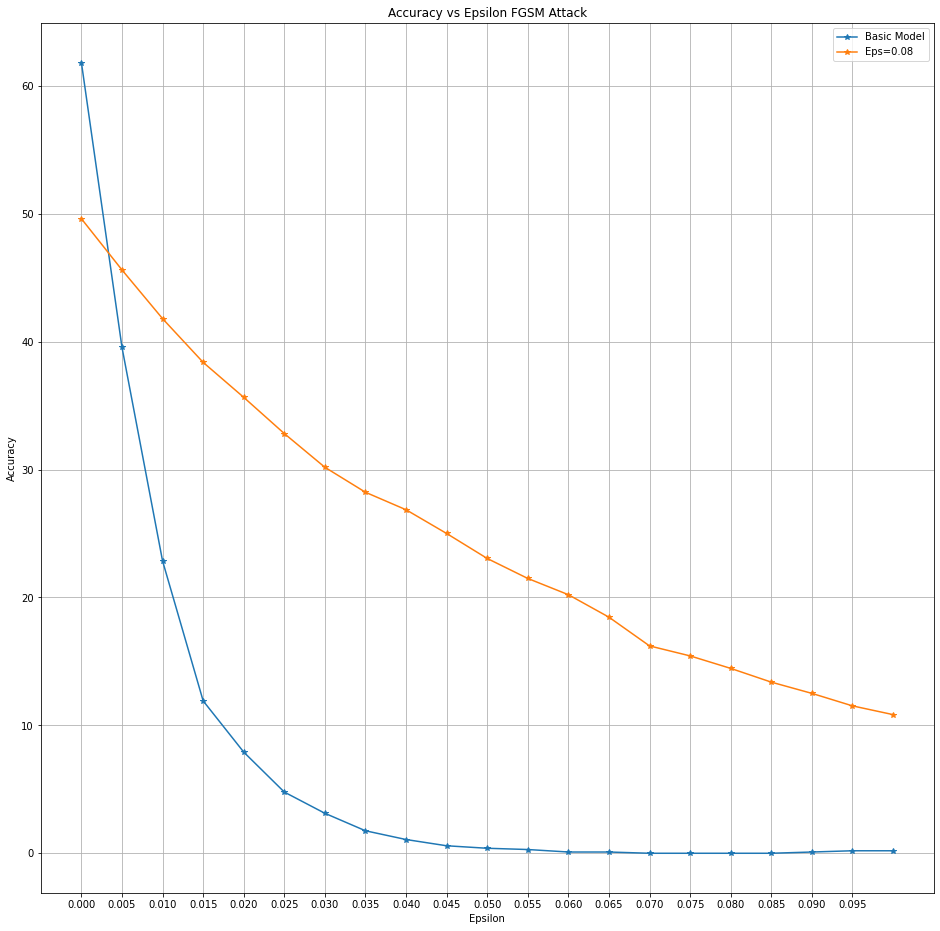

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.plot(epsilons, accuracies_fgsm1, "*-",label="Basic Model")
plt.plot(epsilons, accuracies_fgsm, "*-",label="Eps=0.08")

plt.yticks(np.arange(0, 65, step=10))
plt.xticks(np.arange(0, .1, step=0.005))
plt.title("Accuracy vs Epsilon FGSM Attack")
plt.grid(True)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()